# Learning constants (via Evolutionary Strategy)

In this second tutorial we consider an example with two dimensional input data and we make use of the possibility to add constants to the model. We will thus show how to learn these constants using a purely evolutionary approach.

We will learn:
 * How to introduce ephemeral constants in a symbolic regression problem.
 * How to learn said constants too using an evolutionary strategy.

In [2]:
# Some necessary imports.
import dcgpy
import pygmo as pg
# Sympy is nice to have for basic symbolic manipulation.
from sympy import init_printing
from sympy.parsing.sympy_parser import *
init_printing()
# Fundamental for plotting.
from matplotlib import pyplot as plt
%matplotlib inline

#### 1 - The data

In [68]:
# We load our data from some available ones shipped with dcgpy.
# In this particular case we use the problem ratpol2 from the paper:
# Vladislavleva, Ekaterina J., Guido F. Smits, and Dick Den Hertog.
# "Order of nonlinearity as a complexity measure for models generated by symbolic regression via pareto genetic
# programming." IEEE Transactions on Evolutionary Computation 13.2 (2008): 333-349. 
X, Y = dcgpy.generate_ratpol2d()


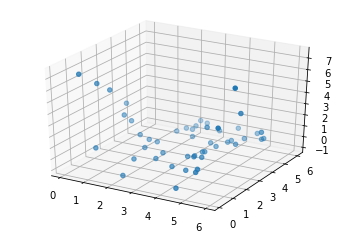

In [81]:
from mpl_toolkits.mplot3d import Axes3D  
# And we plot them as to visualize the problem.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(X[:,0], X[:,1], Y[:,0])



#### 2 - The symbolic regression problem

In [22]:
# We define our kernel set, that is the mathematical operators we will
# want our final model to possibly contain. What to choose in here is left
# to the competence and knowledge of the user. A list of kernels shipped with dcgpy 
# can be found on the online docs. The user can also define its own kernels (see the corresponding tutorial).
ss = dcgpy.kernel_set_double(["sum", "mul", "pdiv"])

In [23]:
# We instantiate the symbolic regression optimization problem
# Note how we specify to consider one ephemeral constant via
# the kwarg n_eph. We also request 100 kernels with a linear 
# layout (this allows for the construction of longer expressions) and
# we set the level back (in an attempt to skew the search towards
# more complex expressions)
udp = dcgpy.symbolic_regression(
    points = X, labels = Y, kernels=ss(), 
    rows = 1, 
    cols = 100, 
    n_eph = 1, 
    levels_back = 80)
prob = pg.problem(udp)
print(udp)

	Data dimension (points): 2
	Data dimension (labels): 1
	Data size: 50
	Kernels: [sum, mul, pdiv]



#### 3 - The search algorithm

In [3]:
# We instantiate here the evolutionary strategy we want to use to
# search for models. Note we specify we want the evolutionary operators
# to be applied also to the constants via the kwarg *learn_constants*
uda  = dcgpy.es4cgp(gen = 400000, mut_n = 2, learn_constants=True)
algo = pg.algorithm(uda)
algo.set_verbosity(1000)

#### 4 - The search

In [39]:
# A 
pop = pg.population(prob, 4)

In [40]:
pop = algo.evolve(pop)

#### 5 - Inspecting the solution

In [41]:
# Lets have a look to the symbolic representation of our model (using sympy)
x = pop.champion_x
a = parse_expr(udp.prettier(x))[0]

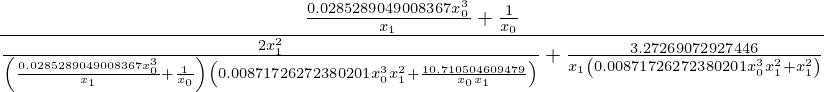

In [51]:
a = a.subs({"c1": x[0]})
a

In [43]:
# And lets see what our model actually predicts on the inputs
Y_pred = udp.predict(X, pop.champion_x)

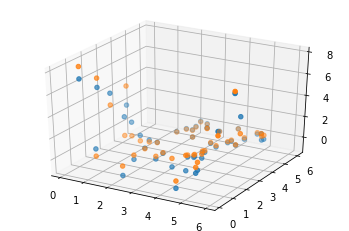

In [83]:
# Lets compare (visually) to the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.scatter(X[:,0], X[:,1], Y[:,0])
_ = ax.scatter(X[:,0], X[:,1], Y_pred[:,0])

#### 6 - Recovering the log


In [45]:
# Here we get the log of the latest call to the evolve
log = algo.extract(dcgpy.es4cgp).get_log()
gen = [it[0] for it in log]
loss = [it[2] for it in log]

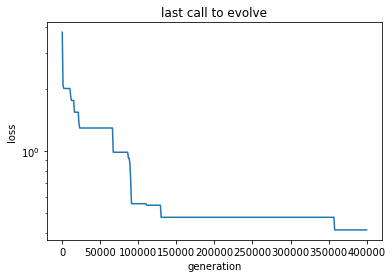

In [47]:
# And here we plot, for example, the generations against the best loss
_ = plt.semilogy(gen, loss)
_ = plt.title('last call to evolve')
_ = plt.xlabel('generation')
_ = plt.ylabel('loss')